In [1]:
!rm -rf /kaggle/working/multimodal-eq-sizing
!git clone https://github.com/brianrp09232000/multimodal-eq-sizing.git /kaggle/working/multimodal-eq-sizing
!pip install -r /kaggle/working/multimodal-eq-sizing/requirements.txt

Cloning into '/kaggle/working/multimodal-eq-sizing'...
remote: Enumerating objects: 858, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 858 (delta 131), reused 95 (delta 94), pack-reused 681 (from 3)
Receiving objects: 100% (858/858), 908.84 KiB | 1.98 MiB/s, done.
Resolving deltas: 100% (526/526), done.


# Modules

In [2]:
import sys
import pathlib

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

import os

In [3]:
np.seterr(invalid="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [4]:
# Uses the current directory where the notebook is running
repo_root = pathlib.Path("multimodal-eq-sizing")
sys.path.append(str(repo_root.resolve())) # .resolve() gets the full absolute path locally

In [5]:
from src.models.price_mlp import rmse, summarize_price_model_diagnostics
from src.models.price_mlp import select_feature_columns, scale_features, create_sliding_windows_single_stock
from src.models.price_mlp import split_single_stock, build_panel_dataset
from src.utils.cv import make_yearly_walkforward_splits, generate_yearly_oof, _train_predict_year

2025-12-08 05:02:06.460373: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765170126.527972     310 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765170126.549567     310 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

# Read Data

In [6]:
df = pd.read_pickle("/kaggle/input/nasdaq-news/proc_multimodal_eq_sizing_dataset.pkl")

In [7]:
#data2 = pd.read_pickle("/kaggle/input/final-dataset-pkl/final_dataset.pkl")

# Source - https://stackoverflow.com/a
# Posted by vboettcher
# Retrieved 2025-12-07, License - CC BY-SA 4.0

#with open('/kaggle/input/final-dataset-pkl/final_dataset.pkl','rb') as handle:
#    data = pickle.load(handle)
# or:
#data = pd.read_pickle('path/to/test.pkl')

# Drop na

In [8]:
df = df.dropna(axis=0, how='any')

# Configurations

In [9]:
################# Configurations #######################
DATA_PATH  = "/kaggle/working/final_dataset.csv"   
DATE_COL   = "Date"                    
TICKER_COL = "ticker"                  
TARGET_COL = "excess_return"             

FEATURE_COLS = ['Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'Dividends',
 'Stock Splits',
 'mom_rank',
 'spy_r1',
 'o2c_return',
 'excess_return',
 'VIX_Close',
 'VIX_z',
 'spread_z',
 'dollar_volume',
 'adv_dollar']

WINDOW_SIZE = 30        
TEST_RATIO  = 0.20      
VAL_RATIO   = 0.10      

BATCH_SIZE   = 64
EPOCHS       = 30
LEARNING_RATE = 1e-3
DROPOUT_RATE = 0.2
GRU_UNITS    = 128
LSTM_UNITS   = 128
DENSE_UNITS  = 64

# Select Feature Columns

In [10]:
def select_feature_columns(df: pd.DataFrame):
    """
    Decide which features to use：
    - if FEATURE_COLS is not None，use this function；
    - o/w use all numerical cols，excluding Date and ticker
    """
    global FEATURE_COLS

    if FEATURE_COLS is not None:
        missing = [c for c in FEATURE_COLS if c not in df.columns]
        if len(missing) > 0:
            raise ValueError(f"FEATURE_COLS is not in the dataset: {missing}")
    else:
        exclude_cols = {DATE_COL, TICKER_COL}
        FEATURE_COLS = [
            c for c in df.columns
            if c not in exclude_cols and pd.api.types.is_numeric_dtype(df[c])
        ]
        print("Auto selected FEATURE_COLS:", FEATURE_COLS)

    if TARGET_COL not in FEATURE_COLS:
        raise ValueError(
            f"TARGET_COL='{TARGET_COL}'must included in the FEATURE_COLS，"
        )

    return FEATURE_COLS

In [11]:
feature_cols = select_feature_columns(df) 

# Scale Features

In [12]:
df_scaled, scaler = scale_features(df, feature_cols)

# Build Model

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

In [14]:
############ change window size to 90 ###################
WINDOW_SIZE = 30  

In [15]:
####################### Build hybrid GRU LSTM model ###################

def build_hybrid_gru_lstm(input_shape):
    """
    input_shape: (WINDOW_SIZE, num_features)

    Input
      → GRU(128, return_sequences=True) + Dropout(0.2)
      → LSTM(128) + Dropout(0.2)
      → Dense(64, relu)
      → Dense(1, linear)
    """
    inputs = layers.Input(shape=input_shape)

    x = layers.GRU(
        GRU_UNITS,
        return_sequences=True,
        dropout=DROPOUT_RATE
    )(inputs)

    x = layers.LSTM(
        LSTM_UNITS,
        dropout=DROPOUT_RATE
    )(x)

    x = layers.Dense(DENSE_UNITS, activation="relu")(x)
    outputs = layers.Dense(1, activation="linear")(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="Hybrid_GRU_LSTM")

    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss="mse",
        metrics=["mae"]
    )

    return model

In [16]:
# Build model
input_shape = (WINDOW_SIZE, len(feature_cols))
model = build_hybrid_gru_lstm(input_shape)
model.summary()

2025-12-08 05:02:17.490685: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "Hybrid_GRU_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 30, 128)        │        56,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 195,969 (765.50 KB)

 Trainable params: 195,969 (765.50 KB)

 Non-trainable params: 0 (0.00 B)

# Train Model

In [17]:
def build_panel_dataset(
    df_scaled: pd.DataFrame,
    feature_cols,
    target_col,
    window_size,
    test_ratio,
    val_ratio
):
    """
    For each stock in the df:
    Construct sliding windows.
    Split into train/validation/test.
    Finally, combine samples from all stocks into one dataset.
    """
    X_train_list, y_train_list = [], []
    X_val_list,   y_val_list   = [], []
    X_test_list,  y_test_list  = [], []

    tickers = df_scaled[TICKER_COL].unique()
    print(f"Total tickers: {len(tickers)}")

    for tic in tickers:
        sub = df_scaled[df_scaled[TICKER_COL] == tic].copy()
        sub = sub.sort_values(DATE_COL)

        X, y = create_sliding_windows_single_stock(
            sub, feature_cols, target_col, window_size
        )

        if len(X) == 0:
            continue

        (X_tr, y_tr,
         X_val, y_val,
         X_te, y_te) = split_single_stock(X, y, test_ratio, val_ratio)

        if X_tr is None:
            continue

        if len(X_tr):
            X_train_list.append(X_tr)
            y_train_list.append(y_tr)
        if len(X_val):
            X_val_list.append(X_val)
            y_val_list.append(y_val)
        if len(X_te):
            X_test_list.append(X_te)
            y_test_list.append(y_te)

    # concatenate all
    X_train = np.concatenate(X_train_list, axis=0)
    y_train = np.concatenate(y_train_list, axis=0)
    X_val   = np.concatenate(X_val_list, axis=0) if X_val_list else np.empty((0, WINDOW_SIZE, len(feature_cols)))
    y_val   = np.concatenate(y_val_list, axis=0) if y_val_list else np.empty((0,))
    X_test  = np.concatenate(X_test_list, axis=0)
    y_test  = np.concatenate(y_test_list, axis=0)

    print("Final shapes:")
    print("  X_train:", X_train.shape, "y_train:", y_train.shape)
    print("  X_val  :", X_val.shape,   "y_val  :", y_val.shape)
    print("  X_test :", X_test.shape,  "y_test :", y_test.shape)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [18]:
# early stopping
es = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

In [ ]:
years = make_yearly_walkforward_splits(df['Date'],2)[-1].train_years
n_rows = len(df_scaled)
start_time = datetime.now()
for year in years[2:]:        
    
    test_samples = len(df_scaled[df_scaled['Date'] >= str(year+1)+'-01-01'])
    val_samples = len(df_scaled[df_scaled['Date'] >= str(year)+'-01-01'])-test_samples
    
    #split data
    X_train, y_train, X_val, y_val, X_test, y_test = build_panel_dataset(
        df_scaled,
        feature_cols,
        TARGET_COL,
        WINDOW_SIZE,
        test_samples/n_rows,
        val_samples/n_rows)

    #print(X_train.shape, y_train.shape)
    """
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val) if len(X_val) else None,
        epochs=1,#epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[es],
        verbose=2)
    """
end_time = datetime.now()
print(end_time-start_time)

# Results from Full Dataset

In [39]:
def create_sliding_windows_single_stock(
    stock_df: pd.DataFrame,
    feature_cols,
    target_col,
    window_size: int
):
    """
    Input: a ticker's time sequence data (sorted by time and normalized）
    Output: X_i, y_i
    - X_i: (n_samples_i, window_size, num_features)
    - y_i: (n_samples_i,)
    """
    data = stock_df[feature_cols].values
    target_index = feature_cols.index(target_col)

    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i: i + window_size, :])                  
        y.append(data[i + window_size, target_index])    

    X = np.array(X)
    y = np.array(y)

    return X, y


In [40]:
def split_single_stock(X, y, test_ratio, val_ratio):
    """
    Split by time for a single ticker:
    Use the earliest (1‒test_ratio) portion as train + validation, and the most recent test_ratio portion as test.
    Then split trainval again so that val_ratio of it becomes the validation set.
    """
    n = len(X)
    if n == 0:
        return (None,) * 6

    test_size = int(n * test_ratio)
    trainval_size = n - test_size

    X_trainval = X[:trainval_size]
    y_trainval = y[:trainval_size]

    X_test = X[trainval_size:]
    y_test = y[trainval_size:]

    val_size = int(trainval_size * val_ratio)
    X_train = X_trainval[:-val_size]
    y_train = y_trainval[:-val_size]
    X_val   = X_trainval[-val_size:]
    y_val   = y_trainval[-val_size:]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [61]:
def build_panel_dataset(
    df_scaled: pd.DataFrame,
    feature_cols,
    target_col,
    window_size,
    test_ratio,
    val_ratio
):
    """
    For each stock in the df:
    Construct sliding windows.
    Split into train/validation/test.
    Finally, combine samples from all stocks into one dataset.
    """
    X_train_list, y_train_list = [], []
    X_val_list,   y_val_list   = [], []
    X_test_list,  y_test_list  = [], []

    tickers = df_scaled[TICKER_COL].unique()
    print(f"Total tickers: {len(tickers)}")

    for tic in tickers:
        sub = df_scaled[df_scaled[TICKER_COL] == tic].copy()
        sub = sub.sort_values(DATE_COL)

        #print('sub', type(sub), len(sub.columns))
        #print(sub)
        X, y = create_sliding_windows_single_stock(
            sub, feature_cols, target_col, window_size
        )
        #print('X', type(X), X.shape)
        #print(X)

        if len(X) == 0:
            continue

        #print('X', type(X), X.shape)
        (X_tr, y_tr,
         X_val, y_val,
         X_te, y_te) = split_single_stock(X, y, test_ratio, val_ratio)

        #print(len(X_tr), len(X_val), len(X_te))
        if X_tr is None:
            continue

        if len(X_tr):
            X_train_list.append(X_tr)
            y_train_list.append(y_tr)
        if len(X_val):
            X_val_list.append(X_val)
            y_val_list.append(y_val)
        if len(X_te):
            X_test_list.append(X_te)
            y_test_list.append(y_te)
        #print()
        
    #print('func', type(X_train_list), X_train_list[0].shape)
    # concatenate all
    X_train = np.concatenate(X_train_list, axis=0)
    y_train = np.concatenate(y_train_list, axis=0)
    X_val   = np.concatenate(X_val_list, axis=0) if X_val_list else np.empty((0, WINDOW_SIZE, len(feature_cols)))
    y_val   = np.concatenate(y_val_list, axis=0) if y_val_list else np.empty((0,))
    X_test  = np.concatenate(X_test_list, axis=0)
    y_test  = np.concatenate(y_test_list, axis=0)

    print("Final shapes:")
    print("  X_train:", X_train.shape, "y_train:", y_train.shape)
    print("  X_val  :", X_val.shape,   "y_val  :", y_val.shape)
    print("  X_test :", X_test.shape,  "y_test :", y_test.shape)

    return X_train, y_train, X_val, y_val, X_test, y_test


In [62]:
X_train, y_train, X_val, y_val, X_test, y_test = build_panel_dataset(
        df_scaled,
        feature_cols,
        TARGET_COL,
        WINDOW_SIZE,
        TEST_RATIO,
        VAL_RATIO
    )

Total tickers: 179
X <class 'numpy.ndarray'> (1421, 30, 16)
X <class 'numpy.ndarray'> (1158, 30, 16)
X <class 'numpy.ndarray'> (1266, 30, 16)
X <class 'numpy.ndarray'> (723, 30, 16)
X <class 'numpy.ndarray'> (1424, 30, 16)
X <class 'numpy.ndarray'> (727, 30, 16)
X <class 'numpy.ndarray'> (943, 30, 16)
X <class 'numpy.ndarray'> (1365, 30, 16)
X <class 'numpy.ndarray'> (599, 30, 16)
X <class 'numpy.ndarray'> (1003, 30, 16)
X <class 'numpy.ndarray'> (1297, 30, 16)
X <class 'numpy.ndarray'> (1163, 30, 16)
X <class 'numpy.ndarray'> (1258, 30, 16)
X <class 'numpy.ndarray'> (1162, 30, 16)
X <class 'numpy.ndarray'> (1267, 30, 16)
X <class 'numpy.ndarray'> (1257, 30, 16)
X <class 'numpy.ndarray'> (1183, 30, 16)
X <class 'numpy.ndarray'> (1206, 30, 16)
X <class 'numpy.ndarray'> (1040, 30, 16)
X <class 'numpy.ndarray'> (1034, 30, 16)
X <class 'numpy.ndarray'> (893, 30, 16)
X <class 'numpy.ndarray'> (658, 30, 16)
X <class 'numpy.ndarray'> (1001, 30, 16)
X <class 'numpy.ndarray'> (1127, 30, 16)
X <

In [21]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val) if len(X_val) else None,
    epochs=3, # epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es],
    verbose=2
)

Epoch 1/3
1463/1463 - 109s - 74ms/step - loss: 8.9057e-04 - mae: 0.0177 - val_loss: 3.9172e-04 - val_mae: 0.0132
Epoch 2/3
1463/1463 - 104s - 71ms/step - loss: 5.0796e-04 - mae: 0.0148 - val_loss: 3.8981e-04 - val_mae: 0.0131
Epoch 3/3
1463/1463 - 103s - 71ms/step - loss: 4.9924e-04 - mae: 0.0145 - val_loss: 4.1354e-04 - val_mae: 0.0138


# Summarize Model Loss and MAE Curves

In [22]:
import matplotlib.pyplot as plt


# plot diagnostic learning curves
def summarize_price_model_diagnostics(model, history):
  """plots price model loss and accuracy curves of the train and validation data
  inputs: model - tensorflow model; history - model.fit output
  outputs: none"""
  fig, ax = plt.subplots(1,2, figsize=(20, 10))
  # plot loss
  ax[0].set_title(model.name+': Loss Curves', fontsize=20)
  ax[0].plot(history.history['loss'], label='train')
  ax[0].plot(history.history['val_loss'], label='validation')
  ax[0].set_xlabel('Epochs', fontsize=15)
  ax[0].set_ylabel('Loss', fontsize=15)
  ax[0].legend(fontsize=15)
  # plot mae
  ax[1].set_title(model.name+': MAE Curves', fontsize=20)
  ax[1].plot(history.history['mae'], label='train')
  ax[1].plot(history.history['val_mae'], label='validation')
  ax[1].set_xlabel('Epochs', fontsize=15)
  ax[1].set_ylabel('MAE', fontsize=15)
  ax[1].legend(fontsize=15)

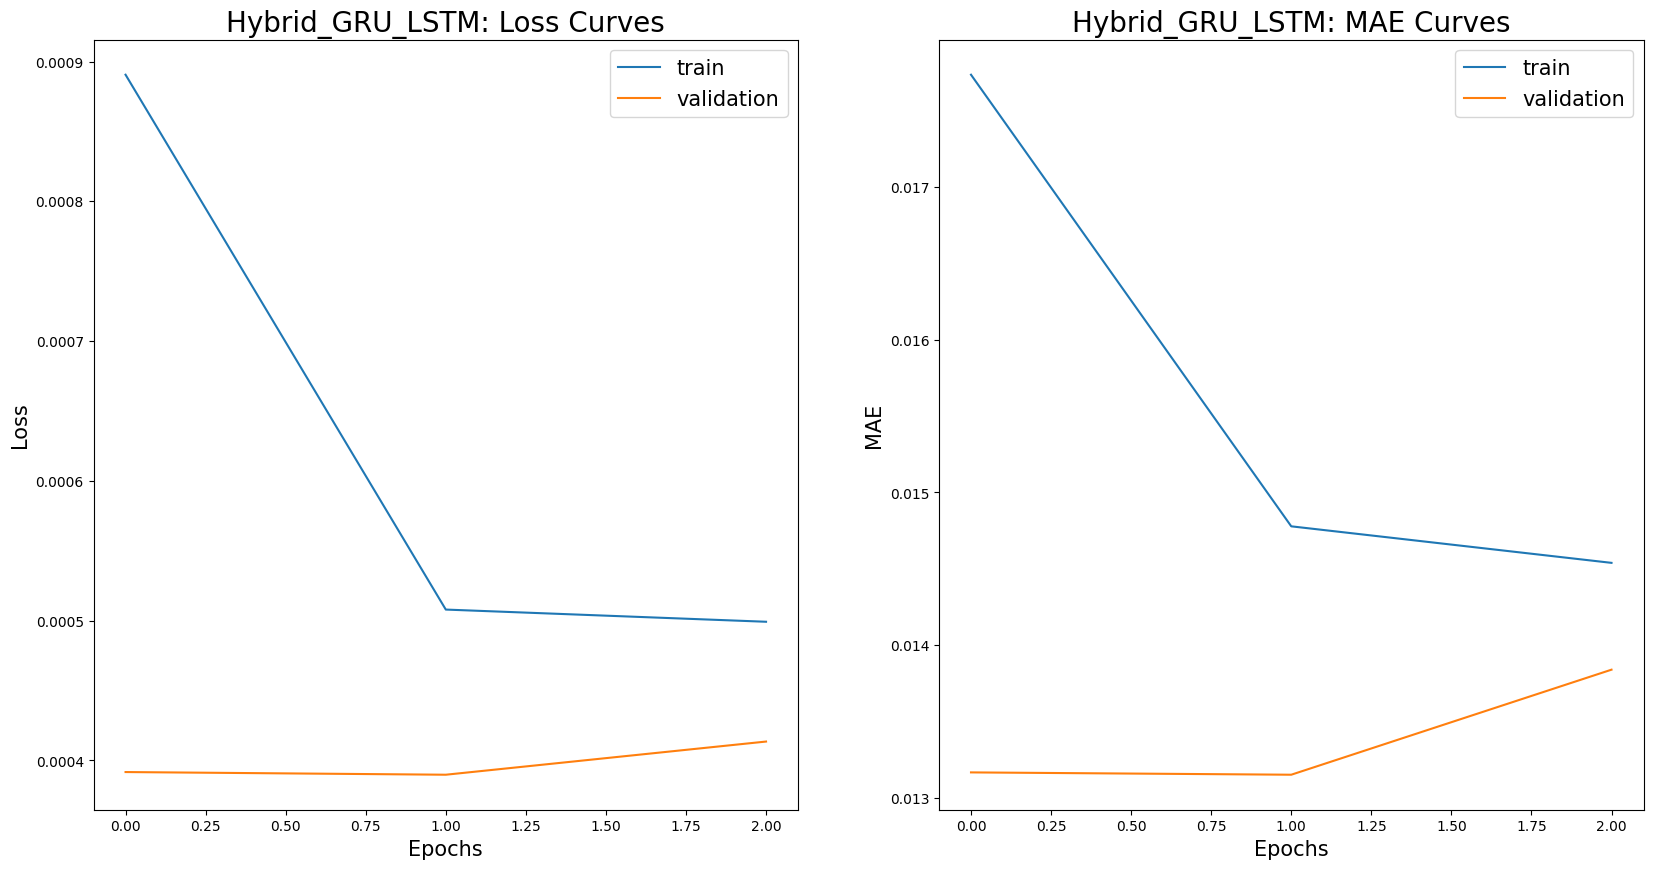

In [23]:
#from src.utils.plotting import summarize_price_model_diagnostics
summarize_price_model_diagnostics(model, history)

# Evaluate Model

In [37]:
y_pred = model.predict(X_test).flatten()

mse  = mean_squared_error(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)
r_mse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Test MSE : {mse:.6f}")
print(f"Test RMSE: {r_mse:.6f}")
print(f"Test MAE : {mae:.6f}")
print(f"Unscaled R2 score (r2): {r2}")

809/809 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step
Test MSE : 0.000500
Test RMSE: 0.022354
Test MAE : 0.015047
Unscaled R2 score (r2): -0.01685124841909036


In [ ]:
df_predict = pd.DataFrame({'y_test': y_test, 'y_predict': y_pred})

In [ ]:
df_predict[:10].to_csv('/kaggle/working/price_model_test_predicted.csv')

In [ ]:
df_predict.to_pickle('/kaggle/working/price_model_test_predicted.pkl')

In [ ]:
# Save the price model 
model.save("/kaggle/working/price_model.keras")

In [ ]:
import kagglehub
handle = "rocklaura/multimodal-eq-sizing"
local_dataset_dir = "/kaggle/working/"
current_datetime = datetime.now().isoformat()
kagglehub.dataset_upload(handle, local_dataset_dir, version_notes=current_datetime)

#saved
handle = ""
local_dataset_directory = ""
current_date = 
kagglehub.dataset = 

In [ ]:
!rm -rf /kaggle/working/multimodal-eq-sizing